In [1]:
from utils.create_folder import create_simulation_folder


In [2]:
results_dir = create_simulation_folder()


[INFO] Simulation folder created: results/2025-10-20_15-41-31


# Corridor restrictions

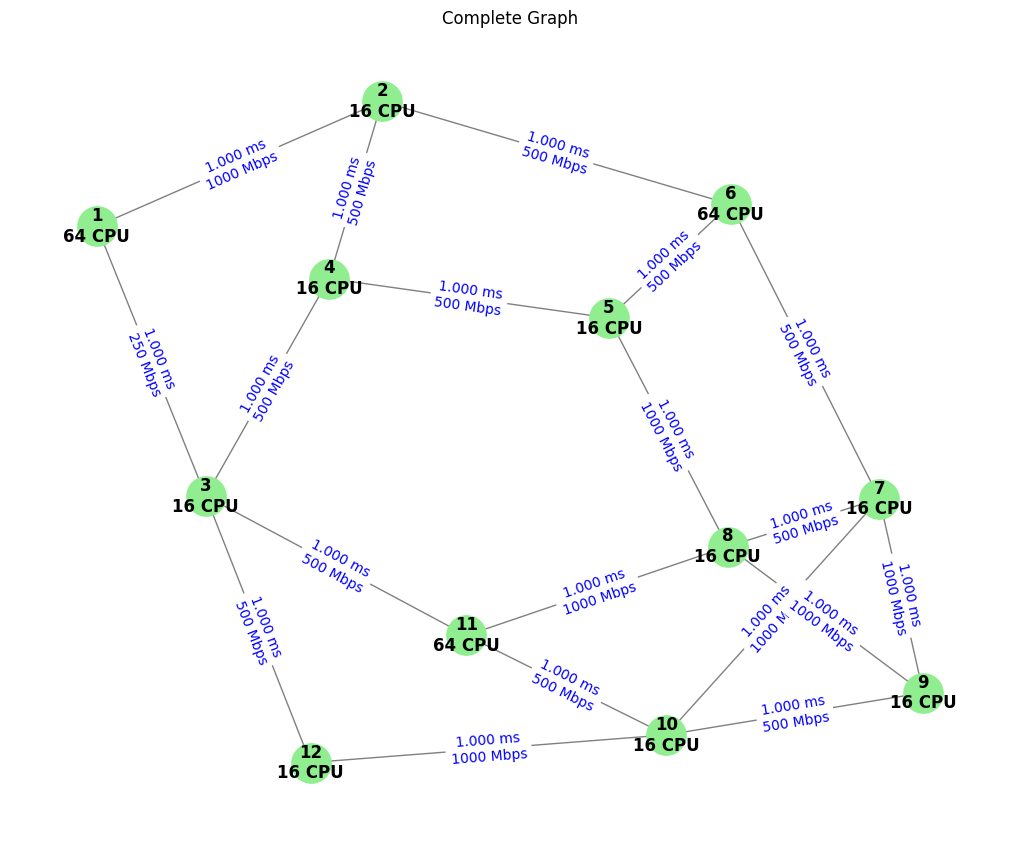

In [3]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()
draw_graph(G)


In [4]:

from utils.generate_slices import generate_random_slices


# === Define corridor in the topology ===
vnf_profiles = [
    {"cpu": 2, "throughput": 40, "latency": 120},
    {"cpu": 4, "throughput": 50, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
    {"cpu": 8, "throughput": 75, "latency": 250}
]
# === Generate slices ===
slices = generate_random_slices(G, vnf_profiles, num_slices=12, num_vnfs_per_slice=3, entry = 6)
slices

[([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf0_0', 'slice': 0},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf0_1', 'slice': 0},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf0_2', 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf1_0', 'slice': 1},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf1_1', 'slice': 1},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf1_2', 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf2_0', 'slice': 2},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf2_1', 'slice': 2},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf2_2', 'slice': 2}],
  

In [5]:

node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}

link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})

link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})


In [6]:
# === Run heuristics inside the corridor ===
from heuristics.a_star import run_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar, EnergyParams

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_energy_aware_a_star, results_energy_aware_a_star = energy_aware_astar(
    G=G,
    slices=slices,
    node_capacity_base=node_capacity_base,
    link_capacity_base=link_capacity_base,
    w_lat=0.6,
    w_energy=0.4,
    energy_params=EnergyParams(
        link_dynamic_w_per_mbps=0.002,
        node_forward_w_per_mbps=0.001
    ))

# === Display results ===
display(df_astar)
display(df_ff)
display(df_abo)
display(df_fabo)
display(df_bestfit)
display(df_energy_aware_a_star)


[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 7 accepted.


[INFO][A*] === Solving slice 8 (VNFs=3, VLs=2) ===
[INFO][A*] Solution foun

,slice,accepted,g_cost
0,1,True,2.0
1,2,True,2.0
2,3,True,2.0
3,4,True,2.0
4,5,True,2.0
5,6,True,2.0
6,7,True,2.0
7,8,True,2.0
8,9,True,2.0
9,10,True,2.0


,slice,accepted,g_cost
0,1,True,5.0
1,2,True,5.0
2,3,True,4.0
3,4,True,4.0
4,5,True,5.0
5,6,True,5.0
6,7,True,6.0
7,8,True,5.0
8,9,True,5.0
9,10,True,6.0


,slice,accepted,g_cost
0,1,True,3.0
1,2,True,3.0
2,3,True,3.0
3,4,True,3.0
4,5,True,3.0
5,6,True,3.0
6,7,True,3.0
7,8,True,3.0
8,9,True,4.0
9,10,True,4.0


,slice,accepted,g_cost
0,1,True,3.0
1,2,True,3.0
2,3,True,3.0
3,4,True,3.0
4,5,True,3.0
5,6,True,3.0
6,7,True,3.0
7,8,True,4.0
8,9,True,4.0
9,10,True,4.0


,slice,accepted,g_cost
0,1,True,4.0
1,2,True,5.0
2,3,True,4.0
3,4,True,5.0
4,5,True,4.0
5,6,True,5.0
6,7,True,4.0
7,8,True,5.0
8,9,True,4.0
9,10,True,5.0


,slice,accepted,g_cost,latency_sum,energy_sum
0,1,True,1.308,2.0,0.27
1,2,True,1.308,2.0,0.27
2,3,True,1.308,2.0,0.27
3,4,True,1.308,2.0,0.27
4,5,True,1.308,2.0,0.27
5,6,True,1.308,2.0,0.27
6,7,True,1.308,2.0,0.27
7,8,True,1.308,2.0,0.27
8,9,True,1.308,2.0,0.27
9,10,True,1.308,2.0,0.27


In [7]:
from utils.generate_graphs import plot_all_routes

In [8]:
plot_all_routes(
    G,
    results_astar,
    title="All A* Routed Paths (All Slices)",
    results_dir=results_dir
)


/home/ceciluz/projects/slicing/simulator/utils/generate_graphs.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to results/2025-10-20_15-41-31/all_a*_routed_paths_(all_slices).png


In [9]:
plot_all_routes(G, bestfit_results, title="All best fit Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-10-20_15-41-31/all_best_fit_routed_paths_(all_slices).png


In [10]:
plot_all_routes(G, ff_results, title="All first fit Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-10-20_15-41-31/all_first_fit_routed_paths_(all_slices).png


In [11]:
plot_all_routes(G, abo_results, title="All ABO Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-10-20_15-41-31/all_abo_routed_paths_(all_slices).png


In [12]:
plot_all_routes(G, fabo_results, title="All FABO Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-10-20_15-41-31/all_fabo_routed_paths_(all_slices).png


In [13]:
plot_all_routes(
    G,
    results_energy_aware_a_star,
    title="All Energy Aware A*  Routed Paths (All Slices)",
    results_dir=results_dir
)

[INFO] Saved route plot to results/2025-10-20_15-41-31/all_energy_aware_a*__routed_paths_(all_slices).png


[MILP] Edge pruning: |E_full|=19 → |E_use|=19 (DEG_LIMIT=3)
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2720135
Academic license 2720135 - for non-commercial use only - registered to ce___@imt-atlantique.fr
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 3000
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  3000
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
P

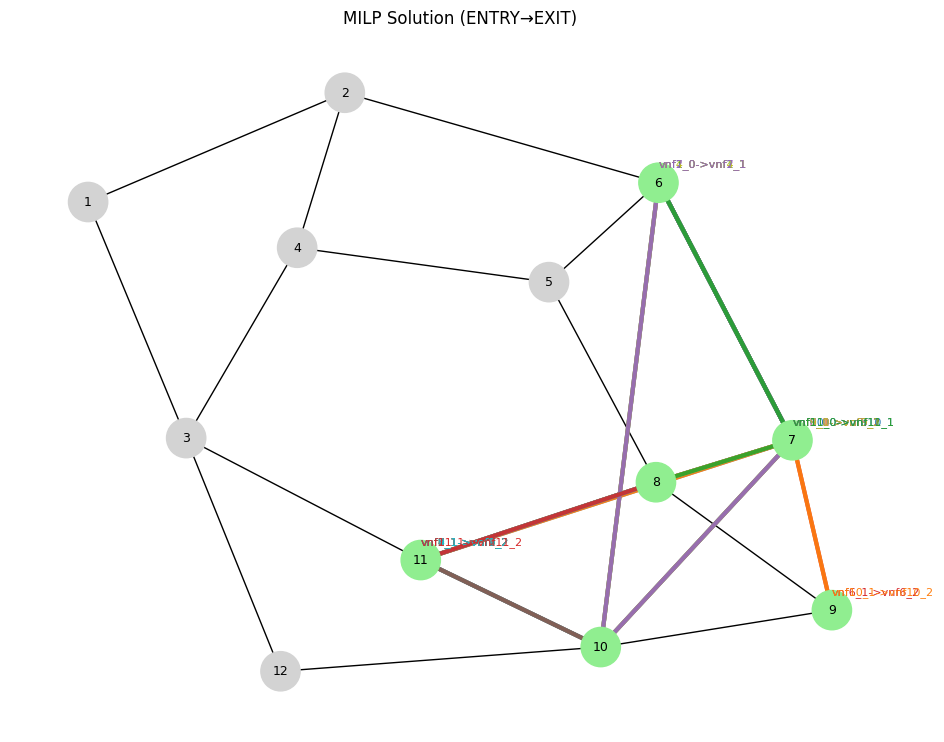

In [14]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi
from milp.create_instance import create_instance
from utils.generate_graphs import plot_solution_heuristic

# === 1. Criar instance ===
instance = create_instance(G, slices)
instance.entry_node = 6

# === 2. Rodar o MILP ===
milp_res = solve_gurobi(instance, msg=True, time_limit=3000)
# === 3. Adaptar e visualizar ===
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
print(milp_adapter) 

plot_solution_heuristic(G, milp_adapter, title="MILP Solution (ENTRY→EXIT)")


In [ ]:
import gurobipy as gp
m = gp.Model()
print("✅ Gurobi kernel is ready!")

✅ Gurobi kernel is ready!


: 

In [15]:
# === Run MILP ===
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

instance = create_instance(G, slices)
milp_res = solve_gurobi(instance, msg=True, time_limit=120)
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)

# === Add all methods to comparison dict ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "A* Energy Aware": results_energy_aware_a_star,
    "First Fit": ff_results,
    "Best Fit": bestfit_results,
    "MILP (Gurobi)": [milp_adapter],   # ⚠️ important: wrap in list
}


[MILP] Edge pruning: |E_full|=19 → |E_use|=19 (DEG_LIMIT=3)
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Academic license 2720135 - for non-commercial use only - registered to ce___@imt-atlantique.fr
Optimize a model with 741 rows, 1178 columns and 5961 nonzeros
Model fingerprint:

In [16]:
from utils.metrics import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new,
    compute_milp_bandwidth_latency,
    count_accepted_slices
)

comparison_rows = []

for method_name, result_list in method_results.items():
    if not result_list:
        continue

    # --- Energy metrics ---
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)
    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    # --- Bandwidth & Latency ---
    if "MILP" in method_name and len(result_list) == 1:
        
        total_bw, total_lat, _, _ = compute_milp_bandwidth_latency(milp_res, instance)
    else:
        total_bw_list = compute_total_bandwidth(result_list, slices)
        total_lat_list = compute_total_latency(result_list, link_latency)
        total_bw = sum(b for b in total_bw_list if b is not None)
        total_lat = sum(l for l in total_lat_list if l is not None)

    # --- Build comparison row ---
    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": total_bw,
        "Total Latency": total_lat,
        "Total Energy": normalized_energy
    })

# --- Final DataFrame ---
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


,Method,Slices Accepted,Total Bandwidth,Total Latency,Total Energy
0,A*,12,1130.0,25.0,28.22875
1,ABO,12,1230.0,41.0,35.22875
2,FABO,12,1280.0,42.0,36.23500
3,A* Energy Aware,12,1120.0,25.0,28.46250
4,First Fit,12,1700.0,62.0,30.64625
5,Best Fit,12,1440.0,54.0,36.88000
6,MILP (Gurobi),12,1500.0,34.0,19.50250


In [17]:
import os
os.makedirs(results_dir, exist_ok=True)


In [18]:
df_milp = pd.DataFrame([
    {
        "slice": len(slices),      # número total de slices
        "accepted": True if milp_adapter else False,
        "g_cost": milp_res.objective if milp_res.objective else None
    }
])


In [19]:
from datetime import datetime

num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)

summary_info = {
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    "num_slices": [num_slices],
    "num_vnfs_total": [num_vnfs_total]
}

import pandas as pd
df_info = pd.DataFrame(summary_info)
df_info.to_csv(f"{results_dir}/experiment_info.csv", index=False)
df_astar.to_csv(f"{results_dir}/astar_results.csv", index=False)
df_energy_aware_a_star.to_csv(f"{results_dir}/energy_aware_a_star.csv", index=False)
df_abo.to_csv(f"{results_dir}/abo_results.csv", index=False)
df_fabo.to_csv(f"{results_dir}/fabo_results.csv", index=False)
df_bestfit.to_csv(f"{results_dir}/bestfit_results.csv", index=False)
df_ff.to_csv(f"{results_dir}/ff_results.csv", index=False)
df_milp.to_csv(f"{results_dir}/milp_results.csv", index=False)
df_metrics.to_csv(f"{results_dir}/metrics.csv", index=False)


In [20]:
with open(f"{results_dir}/log.txt", "w") as f:
    f.write(f"Experiment timestamp: {datetime.now()}\n")
    f.write(f"Number of slices: {num_slices}\n")
    f.write(f"Number of VNFs: {num_vnfs_total}\n")
    f.write("\n=== Summary ===\n")
    f.write(df_astar.to_string(index=False))
    f.write(df_abo.to_string(index=False))
    f.write(df_fabo.to_string(index=False))
    f.write(df_energy_aware_a_star.to_string(index=False))
    f.write(df_bestfit.to_string(index=False))
    f.write(df_ff.to_string(index=False))
    f.write(df_metrics.to_string(index=False))
    f.write("\n\n=== MILP ===\n")
    f.write(df_milp.to_string(index=False))

In [21]:
from utils.generate_graphs import plot_cpu_usage
plot_cpu_usage(G, slices, method_results, results_dir)


[INFO] Saved CPU utilization chart to results/2025-10-20_15-41-31/cpu_utilization.png


In [22]:
from milp.helpers import sanity_check_milp_gurobi
sanity_check_milp_gurobi(milp_res, instance, slices)

=== Sanity check MILP (Gurobi) ===
Objective value: 19.502
Status: 2

Node CPU usage:
  Node 1: used 0.00 / cap 64.00 
  Node 2: used 0.00 / cap 16.00 
  Node 3: used 0.00 / cap 16.00 
  Node 4: used 0.00 / cap 16.00 
  Node 5: used 0.00 / cap 16.00 
  Node 6: used 24.00 / cap 64.00 
  Node 7: used 16.00 / cap 16.00 
  Node 8: used 16.00 / cap 16.00 
  Node 9: used 12.00 / cap 16.00 
  Node 10: used 16.00 / cap 16.00 
  Node 11: used 60.00 / cap 64.00 
  Node 12: used 0.00 / cap 16.00 

[Slice 0]
  VNF vnf0_0 → Node(s) [6]
  VNF vnf0_1 → Node(s) [8]
  VNF vnf0_2 → Node(s) [11]
  VL (vnf0_0->vnf0_1) ✓ routed via [(6, 7), (7, 8)]
  VL (vnf0_1->vnf0_2) ✓ routed via [(8, 11)]
  → Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 → Node(s) [6]
  VNF vnf1_1 → Node(s) [10]
  VNF vnf1_2 → Node(s) [11]
  VL (vnf1_0->vnf1_1) ✓ routed via [(7, 10), (6, 7)]
  VL (vnf1_1->vnf1_2) ✓ routed via [(10, 11)]
  → Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 → Node(s) [6]
  VNF vnf2_1 → Node(s) [10]
  VNF vnf2_2 →

# Load and scalability 

In [ ]:
# === Load & Scalability Experiment ===
# All comments in English

import os, random, time
import numpy as np
import pandas as pd
from copy import deepcopy
from datetime import datetime

# --- Imports ---
from utils.topology import topologie_finlande
from utils.generate_slices import generate_random_slices
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit

from utils.metrics import (
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
    count_accepted_slices,
)

# --- Output directory ---
results_dir = "./results_load_scalability"
os.makedirs(results_dir, exist_ok=True)

# --- Topology ---
G = topologie_finlande()
ENTRY = 6

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [5, 10, 15, 20],
    "num_vnfs_per_slice": [2, 3, 4],
    "seed": [1],
}

records = []

for num_slices in param_grid["num_slices"]:
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        for seed in param_grid["seed"]:
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Running Load Test: {num_slices} slices, {num_vnfs} VNFs, seed={seed} ===")

            # --- Generate slices ---
            slices = generate_random_slices(
                    G,
                    vnf_profiles,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    entry=ENTRY
                )


            # --- Run heuristics ---
            method_results = {}
            method_times = {}

            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
 (G, slices, node_capacity_base, link_capacity_base,
  0.6, 0.4,
  EnergyParams(link_dynamic_w_per_mbps=0.002, node_forward_w_per_mbps=0.001)))


            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- Compute metrics ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })



[INFO] === Running Load Test: 5 slices, 2 VNFs, seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY

: 

In [ ]:

# --- Save & preview ---
df_load = pd.DataFrame(records)
output_path = os.path.join(results_dir, "load_scalability_results.csv")
df_load.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")
display(df_load)



[INFO] Results saved to ./results_load_scalability/load_scalability_results.csv


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec
0,2025-10-20 15:58:54,5,2,1,A*,5,8.80625,200.0,5.0,0.038094
1,2025-10-20 15:58:54,5,2,1,ABO,5,4.13750,200.0,10.0,3.112022
2,2025-10-20 15:58:54,5,2,1,FABO,5,12.59250,200.0,10.0,2.572504
3,2025-10-20 15:58:54,5,2,1,Best Fit,5,8.87500,400.0,19.0,0.002729
4,2025-10-20 15:58:54,5,2,1,First Fit,5,6.72625,200.0,15.0,0.002855
5,2025-10-20 15:59:13,5,3,1,A*,5,16.51875,450.0,10.0,0.106606
6,2025-10-20 15:59:13,5,3,1,ABO,5,16.27500,450.0,15.0,10.497221
7,2025-10-20 15:59:13,5,3,1,FABO,5,17.08750,450.0,15.0,8.942343
8,2025-10-20 15:59:13,5,3,1,Best Fit,5,20.27000,670.0,22.0,0.002439
9,2025-10-20 15:59:13,5,3,1,First Fit,5,15.50125,600.0,23.0,0.001274


In [30]:
from milp.create_instance import create_instance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

MILP_TIME_LIMIT = 300       # Time limit per MILP run (seconds)
ENTRY = 6                   # Fixed entry node
MAX_MILP_SLICES = 30        # Run MILP only if number of slices ≤ this
MAX_MILP_VNFS_TOTAL = 120    # Hard cap: total VNFs (num_slices × num_vnfs) ≤ this

for num_slices in param_grid["num_slices"]:
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        total_vnfs = num_slices * num_vnfs
        for seed in param_grid["seed"]:
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Running Load Test: {num_slices} slices × {num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

            # --- Generate random slices ---
            slices = generate_random_slices(
                G,
                vnf_profiles,
                num_slices=num_slices,
                num_vnfs_per_slice=num_vnfs,
                entry=ENTRY
            )

            method_results = {}
            method_times = {}

            # --- Heuristics ---
            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
 (G, slices, node_capacity_base, link_capacity_base,
  0.6, 0.4,
  EnergyParams(link_dynamic_w_per_mbps=0.002, node_forward_w_per_mbps=0.001)))

            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- MILP (only for small scenarios) ---
            if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                try:
                    print(f"\n[INFO][MILP] Running Gurobi MILP for {num_slices} slices ({total_vnfs} VNFs, limit {MILP_TIME_LIMIT}s)...")
                    start = time.time()

                    instance = create_instance(G, slices)
                    instance.entry_node = ENTRY

                    res = solve_gurobi(instance, msg=False, time_limit=MILP_TIME_LIMIT)
                    milp_adapter = MILPResultAdapterGurobi(res, instance)

                    method_results["MILP (Gurobi)"] = [milp_adapter]
                    method_times["MILP (Gurobi)"] = time.time() - start

                    print(f"[INFO][MILP] Completed in {method_times['MILP (Gurobi)']:.1f}s (status={res.status_str})")

                except Exception as e:
                    print(f"[ERROR][MILP] Failed: {e}")
                    method_results["MILP (Gurobi)"] = []
                    method_times["MILP (Gurobi)"] = None

            else:
                print(f"[SKIP][MILP] Skipped: {num_slices} slices × {num_vnfs} VNFs "
                      f"(total={total_vnfs}) exceeds limit ({MAX_MILP_SLICES} slices or {MAX_MILP_VNFS_TOTAL} VNFs).")

            # --- Compute metrics ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })

# --- Save results ---
df_results = pd.DataFrame(records)
output_path = os.path.join(results_dir, "scalability_results.csv")
df_results.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")



[INFO] === Running Load Test: 5 slices × 2 VNFs (total=10), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 stat

In [31]:
df_results

,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,total_vnfs
0,2025-10-20 15:58:54,5,2,1,A*,5,8.80625,200.0,5.0,0.038094,NaN
1,2025-10-20 15:58:54,5,2,1,ABO,5,4.13750,200.0,10.0,3.112022,NaN
2,2025-10-20 15:58:54,5,2,1,FABO,5,12.59250,200.0,10.0,2.572504,NaN
3,2025-10-20 15:58:54,5,2,1,Best Fit,5,8.87500,400.0,19.0,0.002729,NaN
4,2025-10-20 15:58:54,5,2,1,First Fit,5,6.72625,200.0,15.0,0.002855,NaN
...,...,...,...,...,...,...,...,...,...,...,...
200,2025-10-20 16:29:32,20,4,1,FABO,10,49.69500,1770.0,51.0,60.791603,80.0
201,2025-10-20 16:29:32,20,4,1,Best Fit,8,47.12000,1890.0,52.0,0.010606,80.0
202,2025-10-20 16:29:32,20,4,1,First Fit,13,47.60500,3290.0,91.0,0.015258,80.0
203,2025-10-20 16:29:32,20,4,1,Energy-Aware A*,15,51.93750,3230.0,67.0,0.895126,80.0


In [34]:
import pandas as pd

df = pd.read_csv("./results_load_scalability/scalability_results.csv")
print(df.shape)
print(df.columns)
df.head()


(205, 11)
Index(['timestamp', 'num_slices', 'num_vnfs_per_slice', 'seed', 'method',
       'accepted', 'total_energy', 'total_bandwidth', 'total_latency',
       'runtime_sec', 'total_vnfs'],
      dtype='object')


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,total_vnfs
0,2025-10-20 15:58:54,5,2,1,A*,5,8.80625,200.0,5.0,0.038094,NaN
1,2025-10-20 15:58:54,5,2,1,ABO,5,4.13750,200.0,10.0,3.112022,NaN
2,2025-10-20 15:58:54,5,2,1,FABO,5,12.59250,200.0,10.0,2.572504,NaN
3,2025-10-20 15:58:54,5,2,1,Best Fit,5,8.87500,400.0,19.0,0.002729,NaN
4,2025-10-20 15:58:54,5,2,1,First Fit,5,6.72625,200.0,15.0,0.002855,NaN


In [35]:
summary = (
    df.groupby("method")[["accepted", "total_energy", "total_latency", "runtime_sec"]]
      .mean()
      .sort_values("total_energy")
)
print(summary)


                  accepted  total_energy  total_latency  runtime_sec
method                                                              
MILP (Gurobi)     3.750000      6.254062      13.375000     0.947647
First Fit        10.057143     24.037179      47.828571     0.004788
A*               10.285714     24.211143      23.914286     0.259807
Energy-Aware A*  11.071429     25.543304      26.857143     0.305655
ABO               9.942857     25.975214      34.600000    19.958919
FABO              9.714286     29.202857      32.228571    20.016269
Best Fit          9.371429     29.870000      42.285714     0.004531


In [36]:
comp = (
    df.query("method in ['A*', 'Energy-Aware A*']")
      .groupby(["num_slices", "method"])
      .agg(avg_energy=("total_energy", "mean"),
           avg_latency=("total_latency", "mean"),
           avg_accept=("accepted", "mean"),
           avg_runtime=("runtime_sec", "mean"))
      .reset_index()
)
print(comp.head())


   num_slices           method  avg_energy  avg_latency  avg_accept  \
0           5               A*   17.497500     9.642857         5.0   
1           5  Energy-Aware A*   16.047000     9.000000         5.0   
2          10               A*   21.697500    18.888889        10.0   
3          10  Energy-Aware A*   24.840833    21.666667        10.0   
4          15               A*   33.090417    39.666667        15.0   

   avg_runtime  
0     0.174560  
1     0.140739  
2     0.239344  
3     0.335533  
4     0.349956  


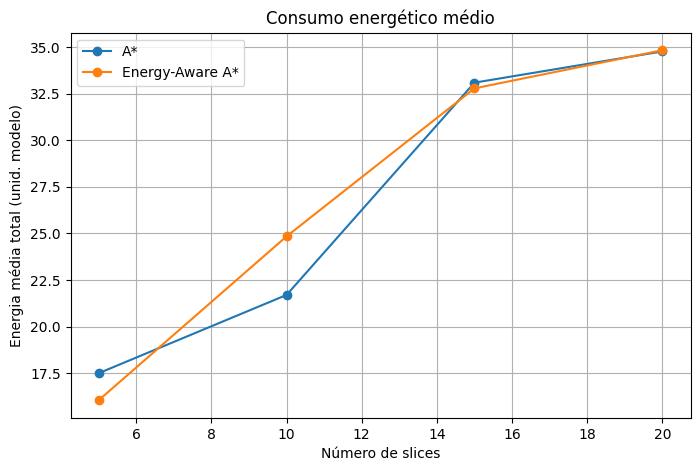

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for m in ["A*", "Energy-Aware A*"]:
    subset = comp[comp["method"] == m]
    plt.plot(subset["num_slices"], subset["avg_energy"], marker="o", label=m)
plt.xlabel("Número de slices")
plt.ylabel("Energia média total (unid. modelo)")
plt.title("Consumo energético médio")
plt.legend()
plt.grid(True)
plt.show()
